In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

try:
    df = pd.read_excel("Online Retail.xlsx")
    print("Loaded Online Retail.xlsx")
except FileNotFoundError:
    try:
        df = pd.read_csv("Online Retail.csv", encoding='latin1')
        print("Loaded Online Retail.csv")
    except FileNotFoundError:
        raise FileNotFoundError(
            "Put 'Online Retail.xlsx' or 'Online Retail.csv' in the working directory. "
            "Download from UCI / Kaggle (Online Retail dataset)."
        )

df.shape, df.columns.tolist()


Loaded Online Retail.xlsx


((541909, 8),
 ['InvoiceNo',
  'StockCode',
  'Description',
  'Quantity',
  'InvoiceDate',
  'UnitPrice',
  'CustomerID',
  'Country'])

In [ ]:
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
if df['InvoiceDate'].dtype == object:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

df = df.dropna(subset=['CustomerID'])
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['CustomerID'] = df['CustomerID'].astype(int)

print("After cleaning:", df.shape)
df.head()


After cleaning: (397884, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [ ]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg(
    Recency = ('InvoiceDate', lambda x: (reference_date - x.max()).days),
    Frequency = ('InvoiceNo', 'nunique'),
    Monetary = ('TotalAmount', 'sum')
).reset_index()

rfm.describe().T


,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.00,13813.250,15299.500,16778.75,18287.00
Recency,4338.0,92.536422,100.014169,1.00,18.000,51.000,142.00,374.00
Frequency,4338.0,4.272015,7.697998,1.00,1.000,2.000,5.00,209.00
Monetary,4338.0,2054.266460,8989.230441,3.75,307.415,674.485,1661.74,280206.02


In [ ]:
def make_quantiles(series, q=4, reverse=False):
    """
    Try to assign quantile labels robustly.
    reverse=True will label best quartile with highest number (e.g., Recency: lower is better -> 4 is best).
    Returns a pandas Series of categorical labels (integers).
    """
    if series.nunique(dropna=True) <= 1:
        if series.isnull().all():
            return pd.Series(np.nan, index=series.index)
        else:
            return pd.Series(1, index=series.index)
    base_labels = list(range(q, 0, -1)) if reverse else list(range(1, q+1))
    try:
        return pd.qcut(series, q, labels=base_labels, duplicates='drop')
    except ValueError:
        try:
            cats, bins = pd.qcut(series, q, retbins=True, duplicates='drop')
            n_bins = len(bins) - 1
            if n_bins <= 0:
                return pd.Series(1, index=series.index)
            if reverse:
                labels2 = list(range(q, q - n_bins, -1))
            else:
                labels2 = list(range(1, 1 + n_bins))
            return pd.cut(series, bins=bins, labels=labels2, include_lowest=True)
        except Exception:
            ranks = series.rank(method='first')
            try:
                return pd.qcut(ranks, q, labels=base_labels, duplicates='drop')
            except Exception:
                return pd.Series(1, index=series.index)

rfm['R_Quartile'] = make_quantiles(rfm['Recency'], q=4, reverse=True)   # Recency: lower = better => label 4 best
rfm['F_Quartile'] = make_quantiles(rfm['Frequency'], q=4, reverse=False)
rfm['M_Quartile'] = make_quantiles(rfm['Monetary'], q=4, reverse=False)

rfm['R_Quartile_num'] = pd.to_numeric(rfm['R_Quartile'], errors='coerce').fillna(0).astype(int)
rfm['F_Quartile_num'] = pd.to_numeric(rfm['F_Quartile'], errors='coerce').fillna(0).astype(int)
rfm['M_Quartile_num'] = pd.to_numeric(rfm['M_Quartile'], errors='coerce').fillna(0).astype(int)

rfm['RFM_Score'] = (
    rfm['R_Quartile_num'].astype(str) +
    rfm['F_Quartile_num'].astype(str) +
    rfm['M_Quartile_num'].astype(str)
)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,R_Quartile_num,F_Quartile_num,M_Quartile_num,RFM_Score
0,12346,326,1,77183.60,1,1,4,1,1,4,114
1,12347,2,7,4310.00,4,3,4,4,3,4,434
2,12348,75,4,1797.24,2,2,4,2,2,4,224
3,12349,19,1,1757.55,3,1,4,3,1,4,314
4,12350,310,1,334.40,1,1,2,1,1,2,112


In [ ]:
def segment_customer(row):
    r, f, m = row['R_Quartile_num'], row['F_Quartile_num'], row['M_Quartile_num']
    if r == 0:
        return 'Unknown'
    if r == 4 and f == 4 and m == 4:
        return 'Champions'
    if r >= 3 and f >= 3:
        return 'Loyal Customers'
    if m == 4 and r >= 3:
        return 'Potential High Value'
    if r >= 3 and f <= 2:
        return 'Recent Customers'
    if r <= 2 and f >= 3:
        return 'At Risk'
    if r <= 2 and f <= 2:
        return 'Lost'
    return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm['Segment'].value_counts().reset_index().rename(columns={'index':'Segment','Segment':'Count'})


,Count,count
0,Lost,2036
1,Recent Customers,1221
2,Loyal Customers,758
3,Potential High Value,209
4,At Risk,114


In [ ]:
print("Top 5 customers by monetary value:")
display(rfm.sort_values('Monetary', ascending=False).head())

rfm.to_csv("rfm_results.csv", index=False)
print("Saved rfm_results.csv to working directory.")


Top 5 customers by monetary value:


,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,R_Quartile_num,F_Quartile_num,M_Quartile_num,RFM_Score,Segment
1689,14646,2,73,280206.02,4,3,4,4,3,4,434,Loyal Customers
4201,18102,1,60,259657.30,4,3,4,4,3,4,434,Loyal Customers
3728,17450,8,46,194550.79,4,3,4,4,3,4,434,Loyal Customers
3008,16446,1,2,168472.50,4,1,4,4,1,4,414,Potential High Value
1879,14911,1,201,143825.06,4,3,4,4,3,4,434,Loyal Customers


Saved rfm_results.csv to working directory.


In [ ]:
marketing_strategies = {
    'Champions': "Offer exclusive discounts, early access to new products, and referral rewards.",
    'Loyal Customers': "Provide loyalty programs, membership benefits, and personalized recommendations.",
    'Potential High Value': "Upsell premium products, send targeted offers, and offer bundles.",
    'Recent Customers': "Send welcome emails, thank-you coupons, and nurture with follow-up offers.",
    'At Risk': "Re-engage with special discounts, personalized win-back campaigns, and surveys.",
    'Lost': "Send reactivation campaigns, clearance offers, or reminders of your best-sellers.",
    'Others': "General promotions, brand awareness campaigns, or seasonal discounts.",
    'Unknown': "Insufficient data to suggest a strategy."
}

rfm['Marketing_Strategy'] = rfm['Segment'].map(marketing_strategies)

rfm[['CustomerID','Segment','RFM_Score','Marketing_Strategy']].head(10)


,CustomerID,Segment,RFM_Score,Marketing_Strategy
0,12346,Lost,114,"Send reactivation campaigns, clearance offers,..."
1,12347,Loyal Customers,434,"Provide loyalty programs, membership benefits,..."
2,12348,Lost,224,"Send reactivation campaigns, clearance offers,..."
3,12349,Potential High Value,314,"Upsell premium products, send targeted offers,..."
4,12350,Lost,112,"Send reactivation campaigns, clearance offers,..."
5,12352,Loyal Customers,334,"Provide loyalty programs, membership benefits,..."
6,12353,Lost,111,"Send reactivation campaigns, clearance offers,..."
7,12354,Lost,113,"Send reactivation campaigns, clearance offers,..."
8,12355,Lost,112,"Send reactivation campaigns, clearance offers,..."
9,12356,Potential High Value,324,"Upsell premium products, send targeted offers,..."


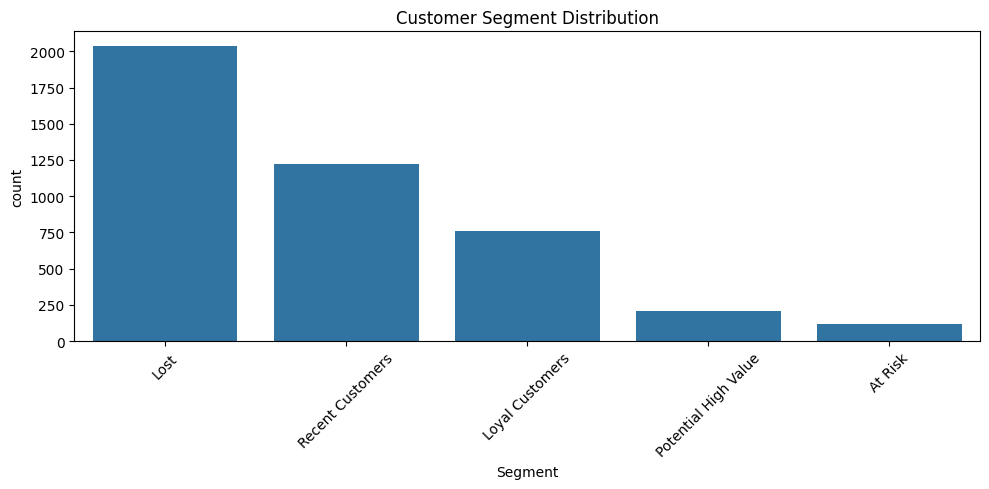

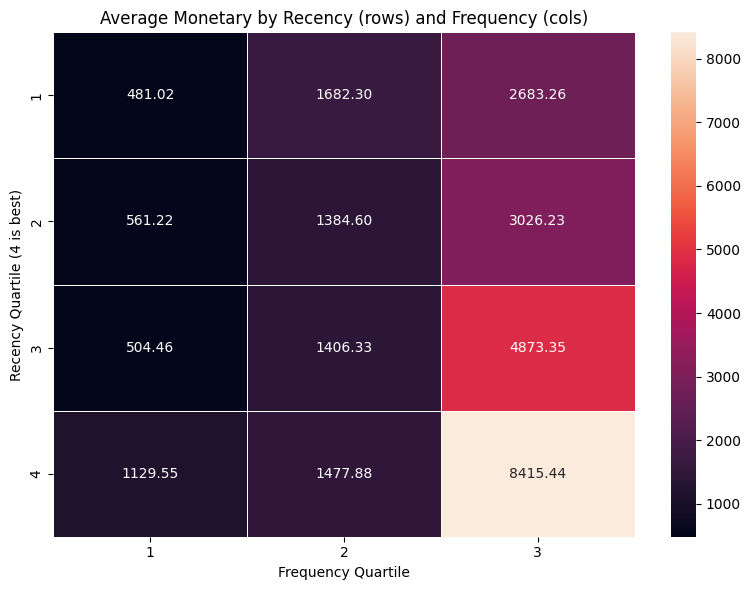

In [ ]:
plt.figure(figsize=(10,5))
order = rfm['Segment'].value_counts().index
sns.countplot(data=rfm, x='Segment', order=order)
plt.xticks(rotation=45)
plt.title("Customer Segment Distribution")
plt.tight_layout()
plt.show()

pivot = rfm.pivot_table(index='R_Quartile_num', columns='F_Quartile_num', values='Monetary', aggfunc='mean')
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".2f", linewidths=.5)
plt.title("Average Monetary by Recency (rows) and Frequency (cols)")
plt.xlabel("Frequency Quartile")
plt.ylabel("Recency Quartile (4 is best)")
plt.tight_layout()
plt.show()
